# Similarity Matching

In [1]:
%run setup.py

In [80]:
# Load data
df_Invited = pd.read_csv(os.path.join(filepath,'factInvited.csv'))
df_Invited['Source'] = "Invited"
df_Proceedings = pd.read_csv(os.path.join(filepath,'factProceedings.csv'))
df_Proceedings['Source'] = "Proceedings"
# Append data to one dataframe
df = df_Invited.append(df_Proceedings).reset_index(drop=True)
df = df[df['Productivity'] != 0]
df['log(Paper Count)'] = np.log(df['Paper Count'])
df['index'] = df.index
df.head(3)

,Full name,Year,Conference (short),First name,Middle name,Last name,gender,Paper Count,Max Paper Count,First year paper,Age,Conference (long),Main Topic,Productivity,Source,log(Paper Count),index
0,Gary L. Baldwi,2004,ASPDAC,Gary,L.,Baldwi,M,4,4,1962,42,Asia and South Pacific Design Automation Confe...,Computer Architecture,0.095238,Invited,1.386294,0
1,Rudy Lauwereins,2004,ASPDAC,Rudy,NaN,Lauwereins,M,112,196,1987,17,Asia and South Pacific Design Automation Confe...,Computer Architecture,6.588235,Invited,4.718499,1
2,Rajeev Madhavan,2005,ASPDAC,Rajeev,NaN,Madhavan,M,5,5,1994,11,Asia and South Pacific Design Automation Confe...,Computer Architecture,0.454545,Invited,1.609438,2


## Method 1 - Cosine Similarity

In [36]:
# Step 1: Group the data by gender
grouped_data = df.groupby('gender')

# Step 2: Calculate the cosine similarity between males and females
male_data = grouped_data.get_group('M')[['Paper Count', 'Age', 'Productivity']].reset_index()
female_data = grouped_data.get_group('F')[['Paper Count', 'Age', 'Productivity']].reset_index()
male_data_norm = (male_data - male_data.mean()) / male_data.std()
female_data_norm = (female_data - female_data.mean()) / female_data.std()
similarity_matrix = cosine_similarity(male_data_norm, female_data_norm)

# Step 3: Create a new column that stores the similar females
df['Similar Females'] = ""
for i, male in male_data.iterrows():
    similarities = similarity_matrix[i] >= .9
    similar_females = female_data.iloc[similarities]
    similar_females_index = similar_females['index'].to_list() # get the index of similar females
    df.loc[male['index'], 'Similar Females'] = ", ".join(map(str, similar_females_index)) # assign to the new column

# Step 4: replace index with names in 'Similar Females' column
name_map = dict(zip(df.index, df['Full name']))
df['Similar Females'] = df['Similar Females'].apply(lambda x: [name_map[int(i)] for i in x.split(',') if i])

df.head()

KeyboardInterrupt: 

In [4]:
# Step 1: create a list of tuples containing all possible combinations of males and females who are similar
links = [(node,name) for node in list(df['Full name'].values) for name in df[df['Full name'] == node]['Similar Females'].values[0]]

# Step 2: remove duplicates
links = list(dict.fromkeys(links))

# Step 3: print
links[0:10]

Check threshold for cosine similarity

In [38]:
# takes about 1 minute
# Step 1: Group the data by gender
grouped_data = df.groupby('gender')

# Step 2: Calculate the cosine similarity between males and females
male_data = grouped_data.get_group('M')[['Paper Count', 'Age', 'Productivity']].reset_index()
female_data = grouped_data.get_group('F')[['Paper Count', 'Age', 'Productivity']].reset_index()
male_data_norm = (male_data - male_data.mean()) / male_data.std()
female_data_norm = (female_data - female_data.mean()) / female_data.std()
similarity_matrix = cosine_similarity(male_data_norm, female_data_norm)

# Step 3: Create a list to store similarity values and plot histogram
similarity_list = []
for i, male in male_data.iterrows():
    similarities = similarity_matrix[i]
    similarity_list.append(similarities)
    
combined_list = np.concatenate(similarity_list).tolist()

KeyboardInterrupt: 

In [ ]:
# takes a loooong time
plt.hist(combined_list, bins=70)
plt.xlabel('Similarity mesure between male and female speakers')
plt.ylabel('Frequency')
plt.title('Distribution of Similarities Between Male and Femlaes Speakers')

## Ratio plot

In [194]:
# Step 0: Select number of iterations
n = 1000

# Step 1: Group the data by gender
grouped_data = df.groupby('gender')

# Step 2: Calculate the cosine similarity between males and females
male_data = grouped_data.get_group('M')[['Paper Count', 'Age', 'Productivity']].reset_index()
female_data = grouped_data.get_group('F')[['Paper Count', 'Age', 'Productivity']].reset_index()
male_data_norm = (male_data - male_data.mean()) / male_data.std()
female_data_norm = (female_data - female_data.mean()) / female_data.std()
similarity_matrix = cosine_similarity(male_data_norm, female_data_norm)

# Step 3: Create a new column that stores the similar females
df['Similar Females'] = ""
for i, male in male_data.iterrows():
    similarities = similarity_matrix[i] >= .9
    similar_females = female_data.iloc[similarities]
    similar_females_index = similar_females['index'].to_list() # get the index of similar females
    df.loc[male['index'], 'Similar Females'] = ",".join(map(str, similar_females_index)) # assign to the new column
    
    # x ---> [ 34, 65, 89] one male speaker can have several similar female

# Step 4: Select a random female by their index n times
ratio_list = []
df['index_list'] = df['Similar Females'].apply(lambda x: [int(i) for i in x.split(',') if i])
for j in tqdm(range(0,n)):
    df['random_index'] = df['index_list'].apply(lambda x: random.choice(x) if len(x) > 0 else None).astype('Int64')
    
    # Step 5: Find the cooresponding informtion about the female speaker and save in new dataframe
    df_filtered = df[(df['gender'] == 'M') & (df['random_index'] != "")]
    df_filtered = df_filtered[['Full name', 'Year','Source','random_index']]
    
    A = pd.merge(df_filtered, df, left_on='random_index', right_on='index', how='left')
    A = A[['Full name_x', 'Source_x', 'Year_x', 'Full name_y', 'Source_y']]
    A = A.rename(columns={'Full name_x': "Full Name_M", 
                                        "Source_x": "source_M",
                                        "Year_x": "year_M",
                                        "Full name_y": "Full Name_F",
                                        "Source_y": "source_F"})
    
    # Step 6: Calculate the ratio of female invited speakers and male invited speakers per year
    P_males = A.groupby('year_M')['source_M'].value_counts(normalize=True).loc[:, 'Invited'].reset_index(name='fraction_M')
    P_females = A.groupby('year_M')['source_F'].value_counts(normalize=True).loc[:, 'Invited'].reset_index(name='fraction_F')
    ratio = np.divide(P_females['fraction_F'],P_males['fraction_M'])
    # Save the list of ratio and add new ratio after each loop
    ratio_list.append(ratio)            
            
# Step 7: Based on the list of fraction by year, calculate the mean and std.
arr = np.array(ratio_list)             
mean_ratio = np.mean(arr[:,:], axis=0)
std_ratio = np.std(arr, axis=0)

100%|██████████| 1000/1000 [01:20<00:00, 12.40it/s]


In [251]:
# df_true = df.groupby(['Year','gender'])['Source'].value_counts(normalize=True).reset_index(name='fraction')
# ratio_true = np.divide(list(df_true[(df_true['gender'] == "F") & (df_true['Source'] == "Invited")]['fraction']), list(df_true[(df_true['gender'] == "M") & (df_true['Source'] == "Invited")]['fraction']))

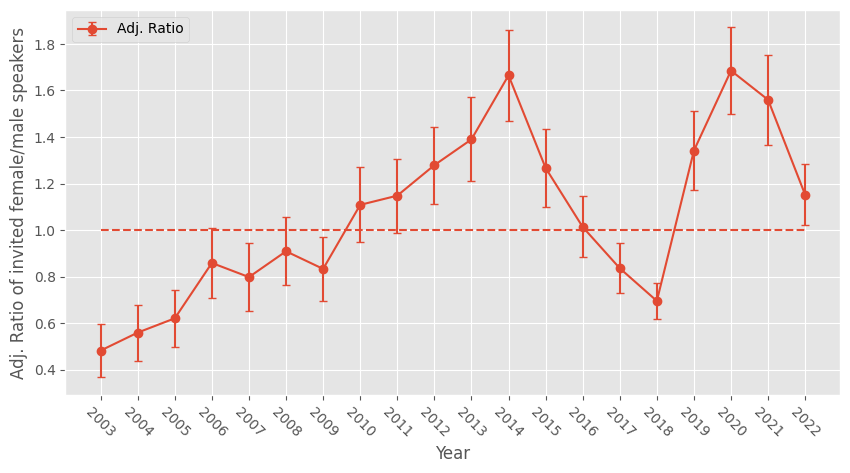

In [263]:
fig = plt.figure(figsize=(10,5))
plt.errorbar(range(2003,2023), mean_ratio, yerr=std_ratio, fmt='o-', capsize=3,label="Adj. Ratio")
# plt.plot(range(2003,2023),ratio_true, label='True Ratio')
plt.xticks(range(2003,2023,1), rotation=315)
plt.hlines(1, 2003, 2022, linestyles='dashed')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Adj. Ratio of invited female/male speakers')
plt.show()

In [3]:
'''
# Step 0: Select number of iterations
n = 1000

# Step 1: Group the data by gender
grouped_data = df.groupby('gender')

# Step 2: Calculate the cosine similarity between males and females
male_data = grouped_data.get_group('M')[['Paper Count', 'Age', 'Productivity']].reset_index()
female_data = grouped_data.get_group('F')[['Paper Count', 'Age', 'Productivity']].reset_index()
male_data_norm = (male_data - male_data.mean()) / male_data.std()
female_data_norm = (female_data - female_data.mean()) / female_data.std()
similarity_matrix = cosine_similarity(male_data_norm, female_data_norm)

# Step 3: Create a new column that stores the similar females
df['Similar Females'] = ""
for i, male in male_data.iterrows():
    similarities = similarity_matrix[i] >= .9
    similar_females = female_data.iloc[similarities]
    similar_females_index = similar_females['index'].to_list() # get the index of similar females
    df.loc[male['index'], 'Similar Females'] = ",".join(map(str, similar_females_index)) # assign to the new column
    
    # x ---> [ 34, 65, 89] one male speaker can have several similar female

# Step 4: Select a random female by their index n times
fractions = {}
df['index_list'] = df['Similar Females'].apply(lambda x: [int(i) for i in x.split(',') if i])
for j in tqdm(range(0,n)):
    df['random_index'] = df['index_list'].apply(lambda x: random.choice(x) if len(x) > 0 else None).astype('Int64')
    
    # Step 5: Find the cooresponding informtion about the female speaker and save in new dataframe
    male_list = []
    female_list = []
    year_list = []
    source_F_list = []
    source_M_list = []

    # filter before the loop
    df_filtered = row['gender'] == 'M' and row['Similar Females'] != ""

    for i, row in df.iterrows():
        if row['gender'] == 'M' and row['Similar Females'] != "":    
            male_list.append(row['Full name'])
            female_list.append(df.loc[row['random_index'],'Full name'])
            year_list.append(int(row['Year']))
            source_F_list.append(df.loc[row['random_index'],'Source'])
            source_M_list.append(row['Source'])
            
    A = pd.DataFrame({
        'name_M': male_list,
        'year_M': year_list,
        'source_M': source_M_list,
        'name_F': female_list,
        'source_F': source_F_list,
    })
            
    # Step 6: Calculate the ratio of female invited speakers per year
    A_grouped = A.groupby(['year_M', 'source_F']).size().reset_index(name='count')
    A_invited = A_grouped[A_grouped['source_F'] == 'Invited']
    A_invited_grouped = A.groupby(['year_M'])['source_F'].count().reset_index(name='total')
    B = pd.merge(A_invited, A_invited_grouped, on='year_M')
    B['fraction'] = B['count'] / B['total'] # number of females invited / total number of speakers for that year
    B = B[['year_M', 'fraction']]
    
    for index, row in B.iterrows():
        year = row['year_M']
        fraction = row['fraction']
        if year in fractions:
            fractions[year].append(fraction)
        else:
            fractions[year] = [fraction]
            
            
# Step 7: Based on the list of fraction by year, calculate the mean and std.             
C = pd.DataFrame(columns=['year', 'mean', 'std'])
for year in fractions:
    mean = sum(fractions[year]) / len(fractions[year])
    std = pd.Series(fractions[year]).std()
    C = C.append({'year': year, 'mean': mean, 'std': std}, ignore_index=True)
C['year'] = C['year'].astype(int)

# Step 8: Save table for reference
C.to_csv('Fraction_of_invited_Females.csv', index=False)
'''

100%|██████████| 1000/1000 [37:28<00:00,  2.25s/it]
